# Compare Time Domain Survey and VASCA catalogs

In [1]:
# General path setup and library loading
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

from jdaviz import Imviz
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as uu
from astropy.table import Table
from astropy.io import fits

from loguru import logger

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

### Load VASCA region

In [2]:
region_name = "TDS"  #_ELAISN1
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
display(rg.tt_fields)

field_id,name,ra,dec,observatory,obs_filter,fov_diam,sel,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id
,,deg,deg,,,deg,,,s,d,d,
bytes22,bytes22,float64,float64,bytes22,bytes22,float32,bool,int32,float32,float64,float64,int32
GNU2592597978464124928,PS_XMMLSS_MOS00,35.578863351058885,-3.14176421214975,GALEX,NUV,1.2,True,27,40457.25,54791.262777777774,57213.3405928096,0
GNU2592668347208302592,PS_XMMLSS_MOS01,36.49984981667359,-3.4923125504146,GALEX,NUV,1.2,True,26,38608.996,54791.33122685185,57205.55893265336,1
GNU2592738715952480256,PS_XMMLSS_MOS02,34.995648096666685,-3.95320684099725,GALEX,NUV,1.2,True,24,23118.55,54791.399976851855,56670.07746654369,2
GNU2592809084696657920,PS_XMMLSS_MOS03,35.87152971805409,-4.25258328683038,GALEX,NUV,1.2,True,21,31699.102,54791.468136574076,57205.5459979022,3
GNU2592879453440835584,PS_XMMLSS_MOS04,36.890941423843685,-4.42319486511272,GALEX,NUV,1.2,True,23,34784.05,54791.53658564815,57214.614389105904,4
GNU2592949822185013248,PS_XMMLSS_MOS05,35.19163328261652,-5.0517494636978,GALEX,NUV,1.2,True,22,32845.8,54791.60503472222,57205.68289605035,5
GNU2593020190929190912,PS_XMMLSS_MOS06,36.220702772470815,-5.20539528501055,GALEX,NUV,1.2,True,23,33876.6,54791.673472222225,57206.85126283999,6
GNU2593653509626789888,PS_CDFS_MOS00,53.10325584718021,-27.796382607231,GALEX,NUV,1.2,True,117,185705.4,54812.34815972222,56994.373020833336,7


### Get TDS & VASCA data and match them positionally

In [3]:
#Select vasca sources, 5 sigma 0.000000573303, 4 sigma 0.00006334, 3 sigma = 0.002699796
sel_flux_cpval = (rg.tt_sources["flux_cpval"]<0.000000573303) * (rg.tt_sources["flux_cpval"]>-0.5)
sel_pos_cpval = rg.tt_sources["pos_cpval"]>1e-10
sel_flux_nxv = rg.tt_sources["flux_nxv"]>0.0006
sel_vasca = sel_flux_cpval* sel_pos_cpval*sel_flux_nxv
rg.tt_sources["sel"][:]=sel_vasca
#sel_vasca = rg.tt_sources["sel"]
tt_vasca = rg.tt_sources[sel_vasca]

# Print cut efficiencies
def print_cuteff(new_sel,pre_sel,cut_label):
    sel_temp = pre_sel*new_sel
    print(f"Selection efficiency {cut_label}: {round(100*sel_temp.sum()/pre_sel.sum(),2)}%")
print_cuteff(sel_flux_cpval,sel_flux_cpval*0+1,"flux_cpval")
print_cuteff(sel_pos_cpval,sel_flux_cpval,"pos_cpval")
print_cuteff(sel_flux_nxv,sel_pos_cpval*sel_flux_cpval,"nxv")

#Read TDS
tt_tds_all = Table.read("./TDS-ApJ_766_60/table4.fit", hdu="J_ApJ_766_60_table4")
ids = tt_tds_all["ID"].data.astype(dtype=str)
sel_elai = (np.char.find(ids, 'ELAI') > -1)
tt_tds = tt_tds_all #tt_tds_all[sel_elai] #
tt_tds['RAJ2000'].name = 'ra'
tt_tds['DEJ2000'].name = 'dec'

#Match VASCA-TDS
pos_tds = SkyCoord(ra=tt_tds["ra"], dec=tt_tds["dec"], unit="deg", frame="icrs")
pos_vasca = SkyCoord(ra=tt_vasca["ra"], dec=tt_vasca["dec"], unit="deg", frame="icrs")

match_dist = 10 * uu.arcsec
idx_tds, dist_tds, _ = pos_vasca.match_to_catalog_sky(pos_tds)
tt_vasca["tds_recno"]=tt_tds[idx_tds]["recno"]
tt_vasca["tds_idx"]=idx_tds
tt_vasca["tds_dist"]=dist_tds.to("arcsec")
tt_vasca["tds_match"] = tt_vasca["tds_dist"] < match_dist

idx_vasca, dist_vasca, _ = pos_tds.match_to_catalog_sky(pos_vasca)
tt_tds["rg_src_id"]=tt_vasca[idx_vasca]["rg_src_id"]
tt_tds["vasca_idx"]=idx_vasca
tt_tds["vasca_dist"]=dist_vasca.to("arcsec")
tt_tds["vasca_match"] = tt_tds["vasca_dist"] < match_dist

display(tt_vasca[:2])
display(tt_tds[:2])

Selection efficiency flux_cpval: 1.4%
Selection efficiency pos_cpval: 92.05%
Selection efficiency nxv: 88.67%


fd_src_id,nr_det,nr_uls,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,pos_rchiq,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,flux_dmaxabs,flux_sigmax,flux_sigmax_dflux,flux_skew,mag,mag_err,sel,rg_fd_id,rg_src_id,nr_fd_srcs,tds_recno,tds_idx,tds_dist,tds_match
,,,deg,deg,arcsec,,arcsec2,,,1e-06 Jy,1e-06 Jy,1e-12 Jy2,1e-12 Jy2,,,1e-06 Jy,,1e-06 Jy,1e-12 Jy2,mag,mag,,,,,,,arcsec,
int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int32,int32,int32,int32,int64,float64,bool
-1,53,0,334.16726431096373,0.2723238551298795,0.08571919,-1.1847866e-07,0.21215984,0.9863203,0.5205102,32.731102,0.18267164,0.0098656565,12.435589,0.0,6.967126,7.297245,5.031066,5.618702,0.3150875,20.112598,0.0060424805,True,-1,2,3,96,95,469.9933226971473,False
-1,15,0,334.13135217280205,0.24217629701402288,0.18364786,-2.2104038e-07,0.3097197,0.5940578,0.6044238,11.959504,0.28402272,0.032858018,5.9468236,1.5862488e-08,4.636558,5.104484,4.4659233,5.104484,-0.5281227,21.205715,0.025482178,True,-1,6,3,96,95,551.0667860879795,False


recno,ID,ra,dec,l_mlow,mlow,l_Dmmax,Dmmax,l_sigint,sigint,l_Sd,Sd,l_Sy,Sy,LC,Mph,rmag,OT,z,X,Class,rg_src_id,vasca_idx,vasca_dist,vasca_match
,,deg,deg,,mag,,mag,,mag,,mag,,mag,,,mag,,,,,,,arcsec,
int32,bytes16,float64,float64,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,bytes3,float32,bytes3,float32,bytes1,bytes12,int32,int64,float64,bool
1,GROTH_MOS01-21,216.1622,54.0911,,22.54,,4.60,,1.04,,0.80,,1.13,V,pt,14.92,Mdw,--,,Mdw,85460,715,177.8799,False
2,VVDS22H_MOS05-05,333.8326,-0.5491,,21.14,,4.47,,0.99,,0.90,,0.74,F,pt,21.24,QSO,--,,CV,25634,292,0.3926,True


In [4]:
sel_tmv = tt_tds["vasca_match"]
sel_vmt = tt_vasca["tds_match"]
print("Nr. sources VASCA/TDS :",len(tt_vasca),"/",len(tt_tds))
print("Nr. associated sources VASCA/TDS:",sel_vmt.sum(),"/",sel_tmv.sum())
print("Fraction of associated VASCA/TDS sources:",sel_vmt.sum()/len(tt_vasca),"/",sel_tmv.sum()/len(tt_tds))

ids_tds = tt_tds["ID"].data.astype(dtype=str)
sel_tds_mos15 = (np.char.find(ids_tds, 'MOS15') > -1)
tt_tds_mos15 = tt_tds[sel_tds_mos15]
print("Total Nr of TDS sources from MOS15:",len(tt_tds_mos15))
display(tt_tds_mos15[tt_tds_mos15["vasca_match"]==False]["recno","ID","ra","dec"])

Nr. sources VASCA/TDS : 1909 / 1078
Nr. associated sources VASCA/TDS: 636 / 638
Fraction of associated VASCA/TDS sources: 0.33315872184389733 / 0.5918367346938775
Total Nr of TDS sources from MOS15: 26


recno,ID,ra,dec
,,deg,deg
int32,bytes16,float64,float64
59,ELAISN1_MOS15-10,242.3832,53.6801
71,ELAISN1_MOS15-20,242.8292,53.7492
127,ELAISN1_MOS15-16,242.7175,53.7547
212,ELAISN1_MOS15-11,242.4293,54.3621
307,ELAISN1_MOS15-03,242.1960,54.0721
390,ELAISN1_MOS15-22,242.8843,53.5921
417,ELAISN1_MOS15-18,242.7775,53.9643
441,ELAISN1_MOS15-13,242.4726,53.6579


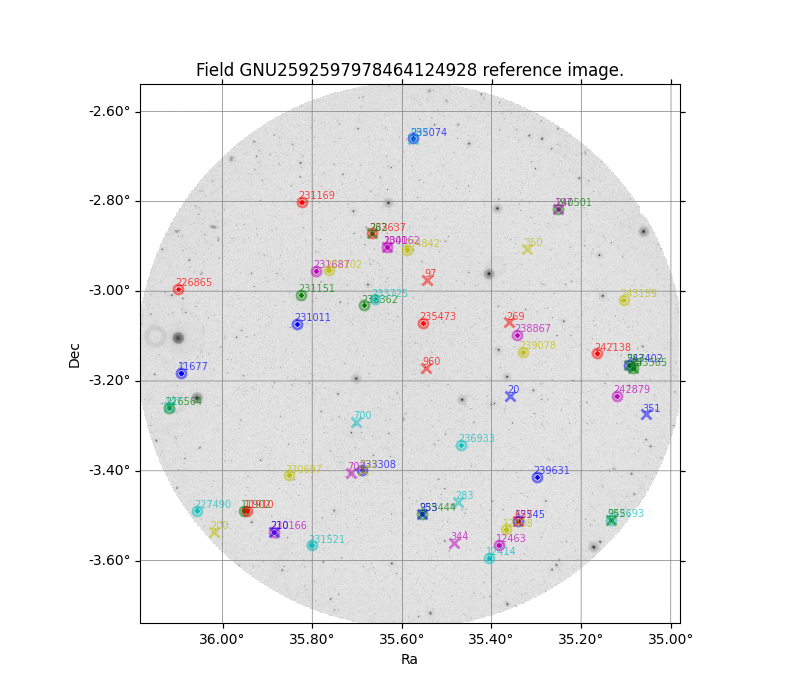

In [5]:
#PS_ELAISN1_MOS15 is field_id GNU2597664528044916736 (TDE PS1-10jh field)
field_id = rg.tt_fields["field_id"][0]
fd = rg.get_field(field_id=field_id, load_method="FITS", add_field=False)

#from astropy.coordinates import Angle, SkyCoord
#from regions import CircleSkyRegion
#center = SkyCoord(243.0512, 54.2599, unit='deg')
#radius = Angle(0.03, 'deg')
#region = CircleSkyRegion(center, radius)

fig, ax = vvis.plot_field_sky_map(fd, img_idx=-1, sky_region = fd.get_sky_region()) # 
ax = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections, src_id="rg_src_id", sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))

plot_tds = {"marker":"x","color":"k"}
ax = vvis.plot_sky_sources(tt_tds, src_id="recno",src_kwargs=plot_tds, sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))

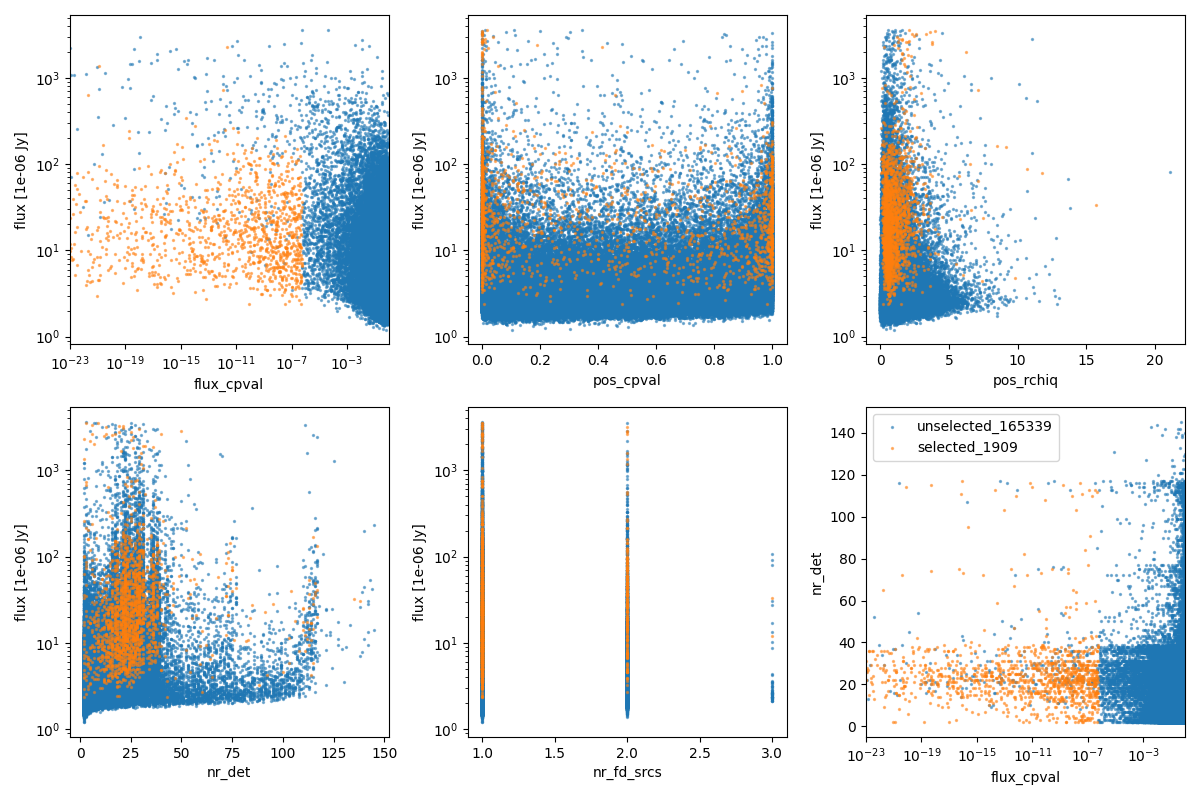

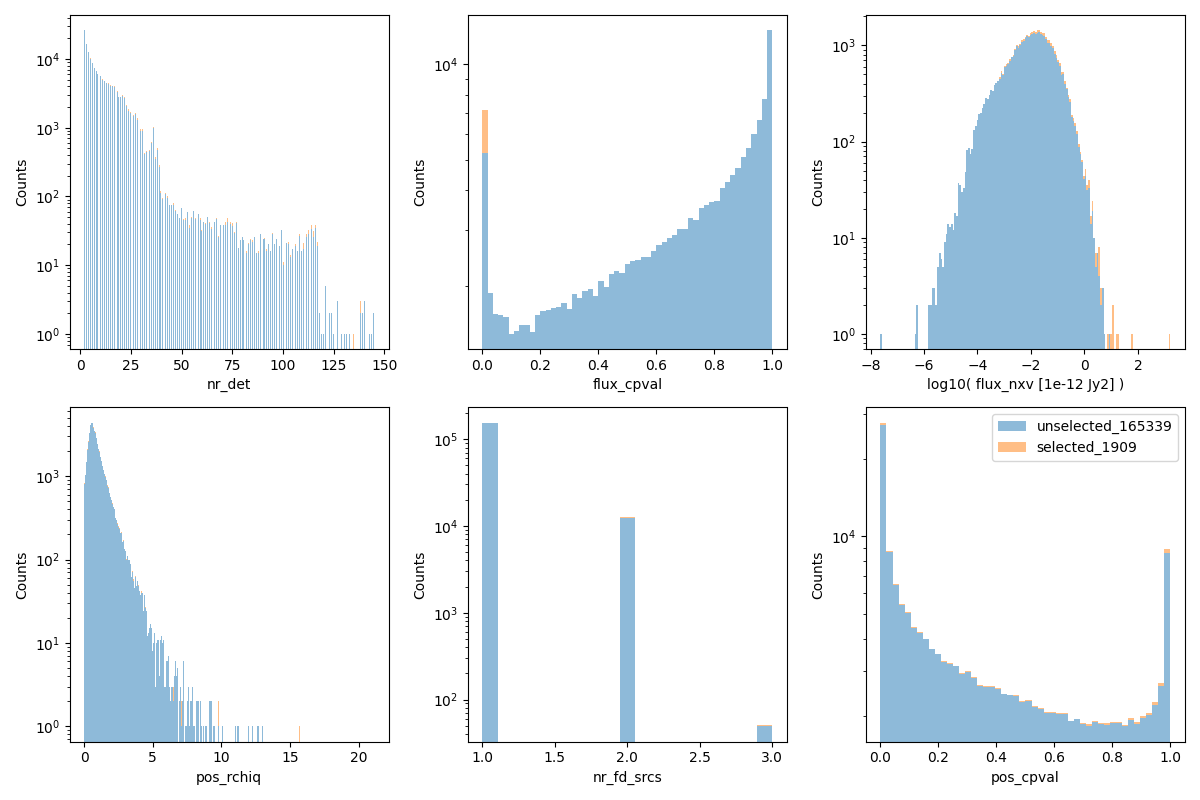

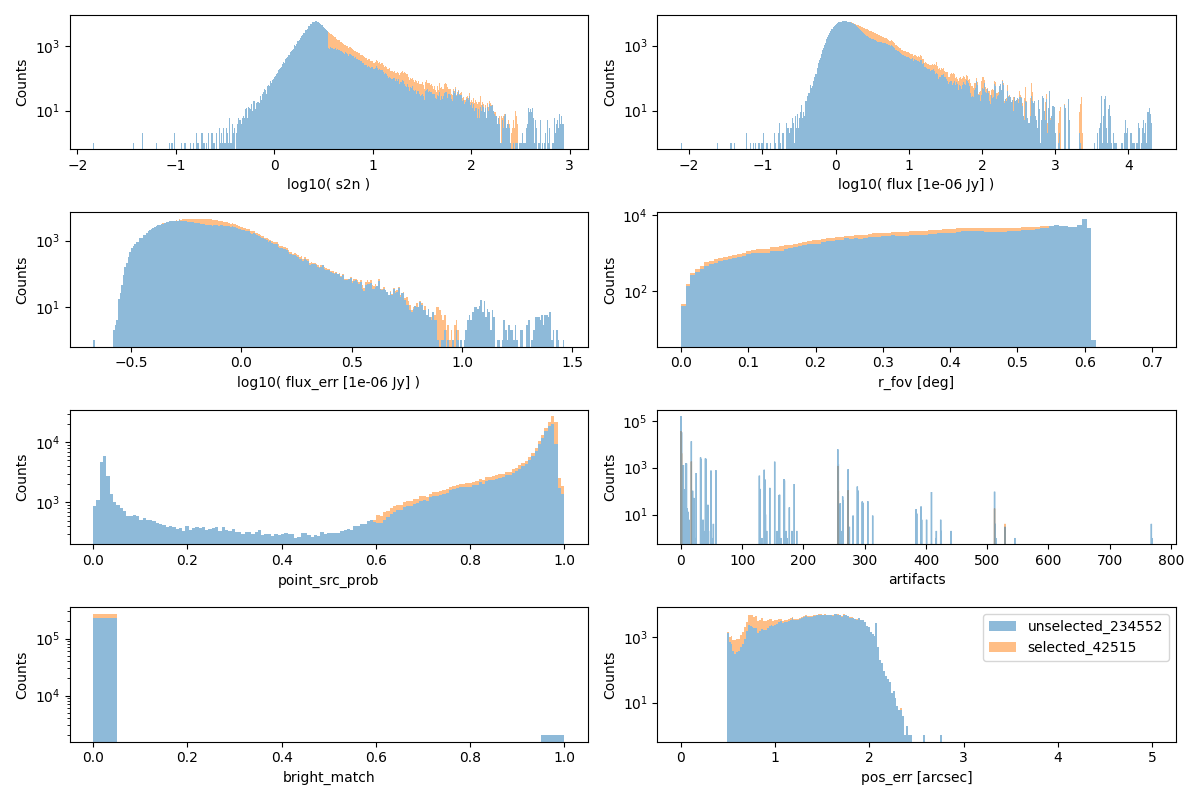

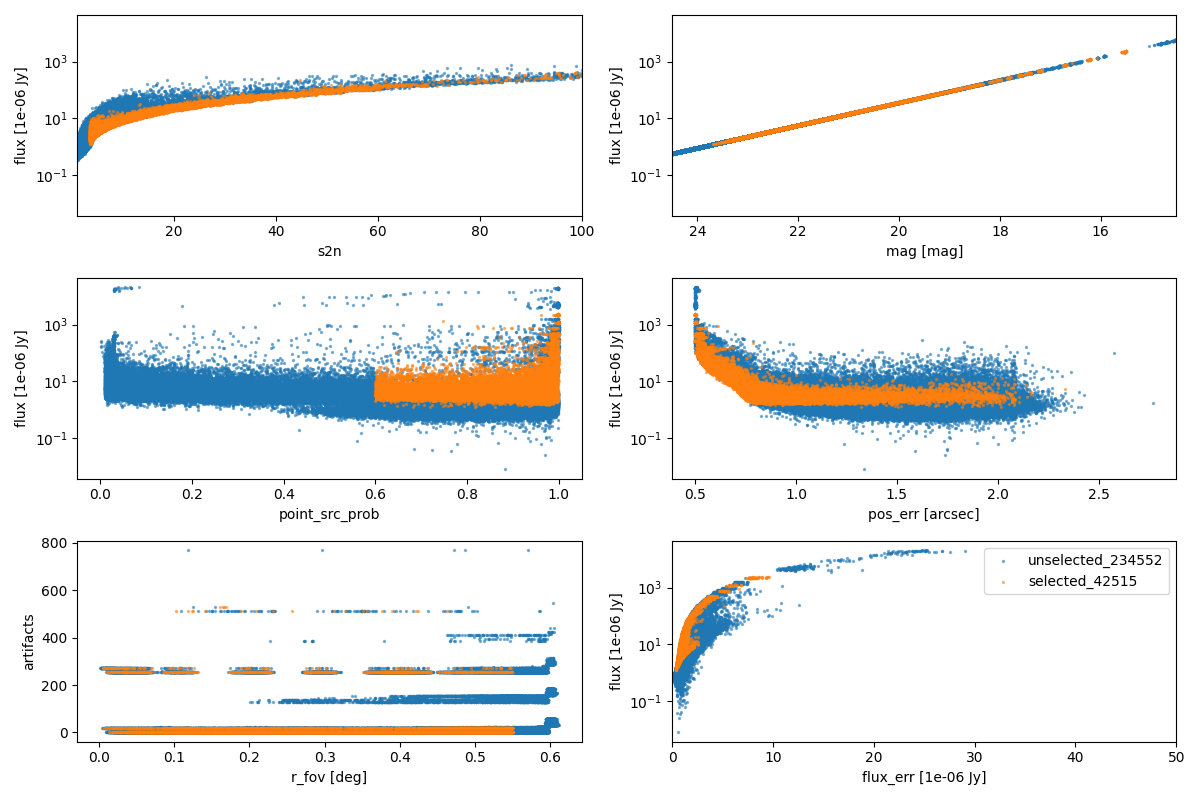

In [6]:
import vasca.visualization as vvis
_= vvis.plot_pipe_diagnostic(rg, "tt_sources", "scatter")
_= vvis.plot_pipe_diagnostic(rg, "tt_sources", "hist")
_= vvis.plot_pipe_diagnostic(fd, "tt_detections", "hist")
_= vvis.plot_pipe_diagnostic(fd, "tt_detections", "scatter")

In [7]:
#71	ELAISN1_MOS15-20	242.8292	53.7492
#307	ELAISN1_MOS15-03	242.1960	54.0721
#390	ELAISN1_MOS15-22	242.8843	53.5921
#417	ELAISN1_MOS15-18	242.7775	53.9643
#441	ELAISN1_MOS15-13	242.4726	53.6579
#495	ELAISN1_MOS15-00	241.6487	54.3255

#127	ELAISN1_MOS15-16	242.7175	53.7547



da = 0.03 #10/3600.
ra_src = 242.77
dec_src = 56.20
sel_ra = (fd.tt_detections["ra"]>ra_src-da)*(fd.tt_detections["ra"]<ra_src+da)
sel_dec = (fd.tt_detections["dec"]>dec_src-da)*(fd.tt_detections["dec"]<dec_src+da)
sel_src = sel_ra*sel_dec
display(fd.tt_detections[sel_src])
print(fd.tt_detections[sel_src]["artifacts"].data)

vis_id,fd_src_id,ra,dec,pos_err,flux,flux_err,s2n,sel,det_id,r_fov,artifacts,point_src_prob,bright_match,flux_f60,flux_f60_err,flux_f38,flux_f38_err,E_bv,mag,mag_err
,,deg,deg,arcsec,1e-06 Jy,1e-06 Jy,,,,deg,,,,,,,,,mag,mag
int64,int32,float64,float64,float32,float32,float32,float32,bool,int64,float32,int64,float32,int32,float32,float32,float32,float32,float32,float32,float32


[]


In [8]:
display(fd.tt_sources[fd.tt_sources["fd_src_id"]==4474])

fd_src_id,nr_det,nr_uls,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,pos_rchiq,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,flux_dmaxabs,flux_sigmax,flux_sigmax_dflux,flux_skew,mag,mag_err,sel
,,,deg,deg,arcsec,,arcsec2,,,1e-06 Jy,1e-06 Jy,1e-12 Jy2,1e-12 Jy2,,,1e-06 Jy,,1e-06 Jy,1e-12 Jy2,mag,mag,
int32,int64,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool
4474,1,0,35.8576326909253,-3.2688660780429224,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-100.0,-1.0,-1.0,True
